In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import subprocess

from tqdm import tqdm

from astropy.io import fits

from lvmdrp.functions import imageMethod
from lvmdrp.functions import rssMethod

import seaborn as sns

sns.set(context="talk", style="ticks", palette="husl", color_codes=True)

In [2]:
# data root path
LVM_DEV = os.path.expandvars("$LVMHUB")
LVM_ROOT = os.path.join(LVM_DEV, "data-califa")
LVM_DATA_LAB = os.path.join(LVM_ROOT, "lab")

In [3]:
frame_paths = sorted([os.path.join(root,file) for root, _, files in os.walk(LVM_ROOT) for file in files if file.endswith(".fits")])
# frame_paths = sorted([os.path.join(root,file) for root, _, files in os.walk(LVM_DATA_LAB) for file in files if file.endswith(".fits") or file.endswith(".fits.gz")])
print(f"frames matched in lab data path: {len(frame_paths)}")

frames matched in lab data path: 10


In [4]:
new_index = pd.MultiIndex.from_tuples(((pd.to_numeric(os.path.basename(os.path.dirname(file)),errors="ignore"),os.path.basename(file)) for file in frame_paths), names=("mjd", "filename"))
frames_header = pd.DataFrame(
    index=new_index,
    columns="OBJECT EXPTIME".split()
)
for idx, frame_path in tqdm(enumerate(frame_paths), total=len(frame_paths), desc="reading metadata from headers", ascii=True):
    try:
        hdr = fits.getheader(frame_path)
    except OSError:
        continue
    for column in frames_header.columns:
        frames_header.iloc[idx].loc[column] = hdr.get(column, np.nan)
frames_header = frames_header.mask(frames_header==-999).reset_index()

reading metadata from headers: 100%|##########| 10/10 [00:00<00:00, 430.89it/s]


In [5]:
frames_header

,mjd,filename,OBJECT,EXPTIME
0,data-califa,run305_00580.fits,cont_obj_1,4
1,data-califa,run305_00581.fits,cont_obj_1_field,16
2,data-califa,run305_00582.fits,arc_obj_1_HgHe,120
3,data-califa,run305_00583.fits,obj_1_p1_IC10,900
4,data-califa,run305_00584.fits,obj_1_p2_IC10,900
5,data-califa,run305_00585.fits,obj_1_p3_IC10,900
6,data-califa,run305_00586.fits,cont_obj_2,4
7,data-califa,run305_00587.fits,cont_obj_2_field,16
8,data-califa,run305_00588.fits,arc_obj_2_HgHe,120
9,data-califa,run305_00589.fits,obj_2_p1_NGC784,900


In [6]:
iframe = 0

print(frames_header.filename.values[iframe])
frame = fits.open(os.path.join(LVM_ROOT,frames_header.filename.values[iframe]))

ny, nx = frame[0].data.shape
data = frame[0].data

frame[0].header

run305_00580.fits


SIMPLE  =                    T / Created with PDL (http://pdl.perl.org)         
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 2048 / length of data axis 1                          
NAXIS2  =                 2056 / length of data axis 2                          
BUNIT   = 'Data Value'                                                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
LONGSTRN= 'OGIP 1.0'           / The HEASARC Long String Convention may be used.
COMMENT   This FITS file may contain long string keyword values that are        
COMMENT   continued over multiple keywords.  The HEASARC convention uses the &  
COMMENT   character at the e

## Continuum lamp extraction

* Cosmic ray detection and correction (`LACosmic_drp`)
* Peak detection along cross-dispersion exis for a given dispersion pixel (`findPeaksAuto_drp`)
* Peak tracing along dispersion axis (`tracePeaks_drp`)
<!-- * Added position table (with fiber mapping information) to traced frame (`includePosTab_drp`) -->
* Subtraction of stray light (`subtractStrayLight`)
* Cross-dispersion FWHM tracing along dispersion axis (`traceFWHM_drp`)
* Extraction of continuum lamp spectra (`extractSpec_drp`)

382 Fibers found


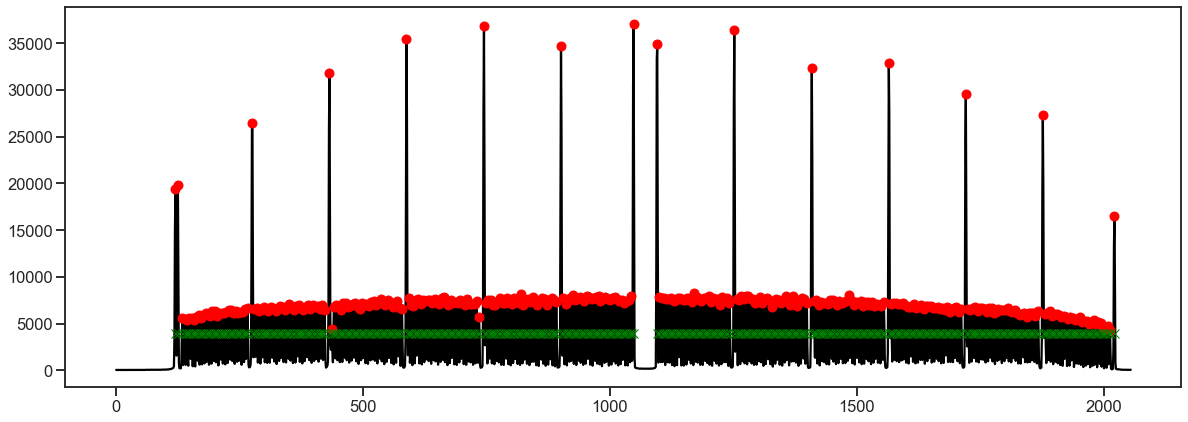

In [7]:
cont_name = "run305_00580"

# remover rayos cosmicos (no es necesario para datos del lab, tiempos de exposicion cortos). El resultado es guardado en *cosmic
imageMethod.LACosmic_drp(os.path.join(LVM_ROOT,f"{cont_name}.fits"), out_image=f"_data/{cont_name}.cosmic.fits", increase_radius=1, flim="1.3", parallel='1')
# deteccion de picos en el eje de cros-dispersion para un pixel dado. El resultado es guardado en *trace
imageMethod.findPeaksAuto_drp(f"_data/{cont_name}.cosmic.fits", out_peaks_file=f"_data/{cont_name}.trace.peaks", nfibers=382)
# trazado de picos, consiste en localizar las fibras a lo largo del eje de cros-dispersion usando la deteccion de picos en el paso anterior
# es equivalente a propagar la localizacion de los picos para un pixel a lo largo del eje de dispersion. El resultado es guardado en *trc
imageMethod.tracePeaks_drp(
    f"_data/{cont_name}.cosmic.fits",
    peaks_file=f"_data/{cont_name}.trace.peaks",
    trace_out=f"_data/{cont_name}.trc.fits",
    steps=30,
    method="gauss",
    threshold_peak=50, poly_disp=5, coadd=30, verbose=0
)
# agregar tabla de posiciones (fiber mapping) al fichero de trazas
# rssMethod.includePosTab_drp(f"_data/{cont_name}.trc.fits", os.path.join(LVM_ROOT,"configs","ppak_382_pt.txt"))
# remover luz directa (stray light). El resultado se guarda en *back (el fondo de luz directa) y *stray (el frame corregido)
imageMethod.subtractStraylight_drp(
    f"_data/{cont_name}.cosmic.fits",
    f"_data/{cont_name}.trc.fits",
    f"_data/{cont_name}.back.fits",
    f"_data/{cont_name}.stray.fits", aperture=40, poly_cross=2, smooth_gauss=30
)

# subprocess.run(f"ds9 _data/{cont_name}.back.fits _data/{cont_name}.stray.fits".split())

# traza el ancho de cada espectro a lo largo de cross-dispersion
# El resultado es guardado en *fwhm
imageMethod.traceFWHM_drp(
    f"_data/{cont_name}.stray.fits",
    f"_data/{cont_name}.trc.fits",
    f"_data/{cont_name}.fwhm.fits",
    blocks=32, steps=30, coadd=20, threshold_flux=50.0, poly_disp=5, clip="1.5,4.0"
)

# subprocess.run(f"ds9 _data/{cont_name}.fwhm.fits".split())

# extraccion (usando el FWHM), usando como entrada el FWHM resultado de traceFWHM_drp. El resultado es guardado en *ms
imageMethod.extractSpec_drp(
    f"_data/{cont_name}.stray.fits",
    f"_data/{cont_name}.trc.fits",
    f"_data/{cont_name}.ms.fits",
    fwhm=f"_data/{cont_name}.fwhm.fits",
    method="optimal", parallel=5
)

In [8]:
# cosmic = fits.open(f"_data/{cont_name}.cosmic.fits")
# trace = fits.open(f"_data/{cont_name}.trc.fits")
# trace.info()

# plt.figure(figsize=(20,10))
# plt.imshow(np.log10(cosmic[0].data), origin="lower")
# plt.gca().set_aspect("auto")
# plt.xlim(0,2000)
# plt.ylim(1800,2000)

# # plt.figure(figsize=(20,))
# xx = np.arange(0, cosmic[0].data.shape[1], 1)
# for iy in range(trace[0].data.shape[0]):
#     yy = trace[0].data[iy,:]
#     plt.plot(xx, yy, "--", color="k")

### Wavelength solution using arc frame

* Build pixel to wavelength map using `pix2wave` script
* Extraction of arc lamp
* Determination of wavelength solution for arc (`detWaveSolution_drp`)
* Add extensions with wavelength solution to FITS file (`createPixTable_drp`)
* Resample spectra to a common wavelength vector (`resampleWave_drp`)

In [9]:
# extraer arco y 3 apuntados (remover stray light en objetos)
# extraccion del arco
arc_name = "run305_00582"
imageMethod.extractSpec_drp(
    os.path.join(LVM_ROOT, f"{arc_name}.fits"),
    f"_data/{cont_name}.trc.fits",
    f"_data/{arc_name}.ms.fits",
    fwhm=f"_data/{cont_name}.fwhm.fits",
    method="optimal", parallel="5"
)

# subprocess.run(f"ds9 _data/{arc_name}.ms.fits".split())

# solucion de longitud de onda
# este paso deberia hacerse en simultaneo con el trazado de la FWHM (espacial), solucion simultanea en espacio y wavelength es el spectroperfectionism
# *.res.fits es la LSF
# *.disp.fits es el muestreo en wavelength
rssMethod.detWaveSolution_drp(
    f"_data/{arc_name}.ms.fits",
    f"_data/{arc_name}.disp.fits",
    f"_data/{arc_name}.res.fits",
    os.path.join(LVM_ROOT,"configs",f"ref_lines_ARC_HgHe_V500.txt"),
    aperture="12", poly_fwhm="-7,-3", poly_dispersion="-7", rel_flux_limits="0.2,2", flux_min="100.0", verbose="1"
)

# subprocess.run(f"ds9 {arc_name}.disp.fits {arc_name}.res.fits".split())
# a#adir solucion a los RSS, usando la determinacion de la solucion de longitud de onda en *disp y *res. El resultado es guardado en *rss
# esto no remuestrea los espectros al mismo vector de longitudes de onda
rssMethod.createPixTable_drp(
    f"_data/{arc_name}.ms.fits",
    f"_data/{arc_name}.rss.fits",
    f"_data/{arc_name}.disp.fits", arc_fwhm=f"_data/{arc_name}.res.fits", cropping=''
)
# remuestrea los espectros a un vector de longitudes de onda comun. Crea *.disp_cor
rssMethod.resampleWave_drp(
    f"_data/{arc_name}.rss.fits", f"_data/{arc_name}.disp_cor.fits",
    start_wave="3745", end_wave="7600", disp_pix="2.0", err_sim="0"
)

# subprocess.run(f"ds9 _data/{arc_name}.rss.fits _data/{arc_name}.disp_cor.fits".split())

Start measuring arc lines...


/home/mejia/.local/lib/python3.8/site-packages/scipy/optimize/minpack.py:476: RuntimeWarning: Number of calls to function has reached maxfev = 9999.
  warnings.warn(errors[info][0], RuntimeWarning)


## Extraction & wavelength calibration of science frame

* Cosmic ray detection and subtraction
* Subtract stray light
* Spectra extraction
* Add wavelength solution
* Resample to common wavelength vector

In [10]:
np.seterr(all='ignore')

object_name = "run305_00583"

imageMethod.LACosmic_drp(
    os.path.join(LVM_ROOT,f"{object_name}.fits"),
    out_image=f"_data/{object_name}.cosmic.fits",
    increase_radius=1, flim="1.3", parallel='5'
)
imageMethod.subtractStraylight_drp(
    f"_data/{object_name}.cosmic.fits",
    f"_data/{cont_name}.trc.fits",
    f"_data/{object_name}.back.fits",
    f"_data/{object_name}.stray.fits",
    aperture=40, poly_cross=2, smooth_gauss=30
)
imageMethod.extractSpec_drp(
    f"_data/{object_name}.stray.fits",
    f"_data/{cont_name}.trc.fits",
    f"_data/{object_name}.ms.fits",
    fwhm=f"_data/{cont_name}.fwhm.fits",
    method="optimal", parallel="5"
)

# subprocess.run(f"ds9 _data/{object_name}.ms.fits".split())

# a#adir informacion de solucion en longitud de onda al objeto y remuestrear
rssMethod.createPixTable_drp(
    f"_data/{object_name}.ms.fits",
    f"_data/{object_name}.rss.fits",
    f"_data/{arc_name}.disp.fits", arc_fwhm=f"_data/{arc_name}.res.fits", cropping=''
)
rssMethod.resampleWave_drp(
    f"_data/{object_name}.rss.fits", f"_data/{object_name}.disp_cor.fits",
    start_wave="3745", end_wave="7600", disp_pix="2.0", err_sim="0"
)

# subprocess.run(f"ds9 _data/{cont_name}.disp_cor.fits _data/{object_name}.disp_cor.fits".split())

/home/mejia/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


## Build fiber flat frame

* Add wavelength solution to continuum lamp & resample to common wavelength vector
* Create fiber flat frame (`createFiberFlat_drp`)
* Fiber flat all frames (continuum, arc and science; `correctFiberFlat_drp`)

In [11]:
# a#adir informacion de solucion en longitud de onda al continuo
rssMethod.createPixTable_drp(
    f"_data/{cont_name}.ms.fits",
    f"_data/{cont_name}.rss.fits",
    f"_data/{arc_name}.disp.fits", arc_fwhm=f"_data/{arc_name}.res.fits", cropping=''
)
# remuestrear continuo
rssMethod.resampleWave_drp(
    f"_data/{cont_name}.rss.fits", f"_data/{cont_name}.disp_cor.fits",
    start_wave="3745", end_wave="7600", disp_pix="2.0", err_sim="0"
)
# crear fiberflat
rssMethod.createFiberFlat_drp(f"_data/{cont_name}.disp_cor.fits", f"_data/fiberflat.fits",
    clip="0.3,1.5", smooth_poly="0", valid="40,200"
)

# subprocess.run(f"ds9 _data/fiberflat.fits".split())

# aplicar correccion por flat
rssMethod.correctFiberFlat_drp(f"_data/{cont_name}.disp_cor.fits", f"_data/{cont_name}.fc.fits", f"_data/fiberflat.fits", clip="0.2")
rssMethod.correctFiberFlat_drp(f"_data/{arc_name}.disp_cor.fits", f"_data/{arc_name}.fc.fits", f"_data/fiberflat.fits", clip="0.2")
rssMethod.correctFiberFlat_drp(f"_data/{object_name}.disp_cor.fits", f"_data/{object_name}.fc.fits", f"_data/fiberflat.fits", clip="0.2")

# subprocess.run(f"ds9 _data/{object_name}.fc.fits".split())

In [12]:
# mejor estimacion del cielo ================
# leer tabla de posiciones
# identificamos cielo
# interpolar cielo en el eje de crosdispersion para toda longitud de onda en la posicion de todas las fibras distintas del cielo
# el resultado debe ser un espectro de cielo por cada fibra != cielo
# hacer esto sobre el ms

## Sky subtraction

* Add position table (with fiber mapping information) to all frames
* Separate sky, object and calibration fibers into different FITS files (`splitFibers_drp`)
* Calculate sky spectrum (`constructSkySpec_drp`)
* Remove sky from science object frame (`subtractSkySpec_drp`)


In [13]:
# a#adir tabla de asignacion de fibras a continuo, arco y objeto
rssMethod.includePosTab_drp(f"_data/{cont_name}.fc.fits", os.path.join(LVM_ROOT,"configs","ppak_382_pt.txt"))
rssMethod.includePosTab_drp(f"_data/{arc_name}.fc.fits", os.path.join(LVM_ROOT,"configs","ppak_382_pt.txt"))
rssMethod.includePosTab_drp(f"_data/{object_name}.fc.fits", os.path.join(LVM_ROOT,"configs","ppak_382_pt.txt"))

# separar fibras de cielo, calibracion y objeto
rssMethod.splitFibers_drp(f"_data/{cont_name}.fc.fits",
    f"_data/{cont_name}.obj.fits,_data/{cont_name}.sky.fits,_data/{cont_name}.cal.fits",
    "OBJ,SKY,CAL"
)
rssMethod.splitFibers_drp(f"_data/{object_name}.fc.fits",
    f"_data/{object_name}.obj.fits,_data/{object_name}.sky.fits,_data/{object_name}.cal.fits",
    "OBJ,SKY,CAL"
)

# subprocess.run(f"ds9 _data/{object_name}.obj.fits".split())

# extraccion del cielo
rssMethod.constructSkySpec_drp(f"_data/{object_name}.sky.fits", f"_data/{object_name}.sky_spec.fits", clip_sigma="1.0")
rssMethod.subtractSkySpec_drp(f"_data/{object_name}.obj.fits", f"_data/{object_name}.sobj.fits", f"_data/{object_name}.sky_spec.fits")

# subprocess.run(f"ds9 _data/{object_name}.sky_spec.fits".split())
# subprocess.run(f"ds9 _data/{object_name}.obj.fits _data/{object_name}.sobj.fits".split())

In [ ]:
# flux calibration
# need the extinction of the sky in the observatory
# calculate the transmission curve (rssMethod.createSensFunction_drp)
# look for the flux_calib.pl

In [14]:
# usar stray y fwhm frames para proyectar cualquier espectro en la CCD.
# proyectar espectro de entrada en la respuesta del instrumento usando la traza y el FWHM
# imageMethod.testres_drp(f"_data/{object_name}.stray.fits", f"_data/{cont_name}.trc.fits", f"_data/{cont_name}.fwhm.fits", f"_data/{object_name}.ms.fits")